# CAP 6618 - Machine Learning for Computer Vision

## Project 4: Image classification using Transfer Learning
Design and implement a complete solution to the problem of image classification using the transfer learning paradigm.

### Educational Objectives
* Learn how to implement different variants of transfer learning for image classification in Keras
* Learn how to evaluate and fine-tune the performance of different classifiers

### Dataset / Documentations
* https://www.cs.toronto.edu/~kriz/cifar.html
* https://keras.io/api/applications/

### Transfer Learning

#### Transfer Learning workflow [ Solution 4 ]:
1. Instantiate a base model by taking layers from a previously trained model except the top layer and load pre-trained weights into it. 
2. Freeze these based layer to avoid destroying any of the information they contain during future training rounds.
3. Create a new model on top of the output of one (or several) layers (trainable layers) from the base model. They will learn to turn the old features into predictions on a new dataset.
4. Train the new layers on your dataset.
5. [OPTIONAL] Fine-tuning which consists of unfreezing the entire model you obtained above (or part of it), and re-training it on the new data with a very low learning rate. This can potentially achieve meaningful improvements, by incrementally adapting the pretrained features to the new data.

#### An alternative and more lightweight workflow [ Solution 3 ]:
1. Instantiate a base model and load pre-trained weights into it.
2. Run your new dataset through it and record the output of one (or several) layers from the base model. This is called feature extraction.
3. Use that output as input data for a new, smaller model.

Source: https://keras.io/guides/transfer_learning/


To Learn More, please visit:
* https://codelabs.developers.google.com/codelabs/keras-flowers-transfer-learning/#0
* https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/
* https://keras.io/guides/transfer_learning/
* https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751

## Step 1: Setup

Make sure that you have installed Keras on your computer

In [1]:
# Imports
from __future__ import print_function

# Common Imports
import numpy as np
import random
import os

# Matplotlib
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Keras
import keras
from keras import applications
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as k 

Using TensorFlow backend.


## Step 2: Classify an image using a pretrained (on ImageNet) model (ResNet50)

In [2]:
# Load pretrained ResNet50 model
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

model = ResNet50(weights='imagenet')
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

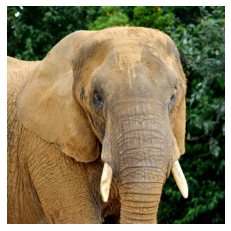

Top 3 Predictions: [('n02504458', 'African_elephant', 0.91064346), ('n01871265', 'tusker', 0.052688293), ('n02504013', 'Indian_elephant', 0.036663424)]


In [3]:
# Use ResNet50 to make prediction on a sample image (input shape is 224x224)

# Load and preprocess image input
img_path = 'elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Plot the image
img = mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

# Make prediction and print result
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/imagenet_utils/decode_predictions
preds = model.predict(x)
print('Top 3 Predictions:', decode_predictions(preds, top=3)[0])

## Step 3: Load and Split the CIFAR10 dataset 

In [4]:
# https://keras.io/api/datasets/cifar10/
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [5]:
# Explore the dataset
print('x_train shape:', x_train.shape)
print('Train Samples: ', x_train.shape[0])
print('Test Samples: ', x_test.shape[0])

x_train shape: (50000, 32, 32, 3)
Train Samples:  50000
Test Samples:  10000


## Step 4: Visualize a sample of the CIFAR-10 dataset

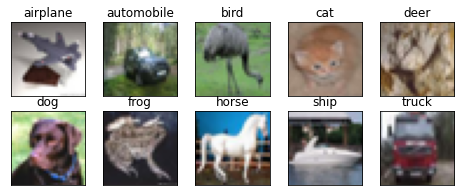

In [6]:
# Source http://parneetk.github.io/blog/cnn-cifar10/

# Plot a sample of each class
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
num_classes = len(class_names)

for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = np.transpose(features_idx[img_num, ::], (0, 1, 2))
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

## Step 5: Prepare the data

In [7]:
# Data Preprocessing 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Digit classes from 0 to 9 (10 classes in total)
num_classes = 10

# Convert Class Vectors to Binary Class Matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Step 6: Model Preparation 

In [8]:
# Training Configuration for Solution 1 & Solution 2
batch_size = 64
epochs = 25

In [9]:
# Model Adapted from https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py

def create_keras_model():
    """ Creates, complies, and returns a Keras model which use in Solution 1 & Solution 2"""
    
    # Create Model 
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=x_train.shape[1:], activation='relu'))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(loss=keras.losses.categorical_crossentropy, metrics=['accuracy'],
                      optimizer=keras.optimizers.rmsprop(lr=0.0001, decay=1e-6))

    return model

## Step 7:  [ Solution 1 ] Classify images using a CNN built from scratch

In [10]:
# Saving model configuration
save_dir = os.path.join(os.getcwd(), 'saved_models')
CNN_model_name = 'CNN_cifar10_trained_model.h5'

In [11]:
# Create the Model
CNN_model = create_keras_model()
CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)         

In [12]:
# Train the model
CNN_history = CNN_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_test, y_test), shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 155us/step - loss: 2.1162 - accuracy: 0.1930 - val_loss: 1.9970 - val_accuracy: 0.2559
Epoch 2/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.8332 - accuracy: 0.3087 - val_loss: 1.6682 - val_accuracy: 0.3868
Epoch 3/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.6791 - accuracy: 0.3736 - val_loss: 1.4945 - val_accuracy: 0.4460
Epoch 4/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.5459 - accuracy: 0.4320 - val_loss: 1.3938 - val_accuracy: 0.4874
Epoch 5/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.4513 - accuracy: 0.4669 - val_loss: 1.3275 - val_accuracy: 0.5208
Epoch 6/25
50000/50000 [==============================] - 7s 131us/step - loss: 1.3698 - accuracy: 0.5030 - val_loss: 1.2420 - val_accuracy: 0.5491
Epoch 7/25
50000/50000 [==============================] - 6s 1

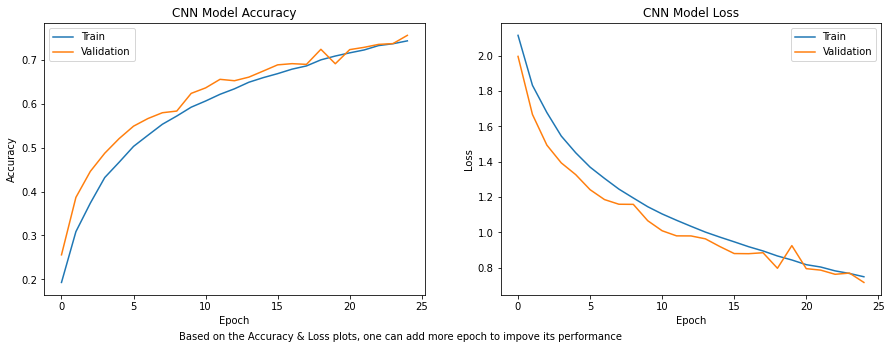

In [13]:
# https://matplotlib.org/3.3.1/api/_as_gen/matplotlib.pyplot.subplot.html
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.text.html

# Plot Model Accuracy and Loss
fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(CNN_history.history['accuracy'])
axs[0].plot(CNN_history.history['val_accuracy'])
axs[0].set_title('CNN Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='best')

axs[1].plot(CNN_history.history['loss'])
axs[1].plot(CNN_history.history['val_loss'])
axs[1].set_title('CNN Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='best')

fig.text(0.25, 0, "Based on the Accuracy & Loss plots, one can add more epoch to impove its performance")
plt.show()

In [14]:
# https://keras.io/getting_started/faq/#what-are-my-options-for-saving-models

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

CNN_model_path = os.path.join(save_dir, CNN_model_name)
CNN_model.save(CNN_model_path)
print('Saved Trained Model')

Saved Trained Model


In [15]:
# Evaluate performance
CNN_scores = CNN_model.evaluate(x_test, y_test, verbose=1)
print('Test Accuracy:', CNN_scores[1])
print('Test Loss:', CNN_scores[0])

10000/10000 [==============================] - 1s 104us/step
Test Accuracy: 0.7559999823570251
Test Loss: 0.716627716255188


## Step 8:  [ Solution 2 ] Perform Data Augmentation on CNN Model Built in Solution 1

In [16]:
# Adapted from https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# https://keras.io/api/preprocessing/image/

# Data Augmentation
datagen = ImageDataGenerator(
                rotation_range=10,      # randomly rotate images in the range (degrees, 0 to 180)
                width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.2, # randomly shift images vertically (fraction of total height)
                fill_mode='nearest',    # set mode for filling points outside the input boundaries
                horizontal_flip=True,   # randomly flip images
                vertical_flip=False,    # randomly flip images
                validation_split=0.0)   # fraction of images reserved for validation (strictly between 0 and 1)

# Fit the training dataset
datagen.fit(x_train)

In [17]:
# Create a Model similar to Solution 1
CNN_Data_Aug_model = create_keras_model()

# Fit the model on the batches generated by datagen.flow().
CNN_Data_Aug_history = CNN_Data_Aug_model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                                                        epochs=epochs,validation_data=(x_test, y_test))

Epoch 1/25
782/782 [==============================] - 19s 25ms/step - loss: 2.1388 - accuracy: 0.1755 - val_loss: 1.9330 - val_accuracy: 0.2613
Epoch 2/25
782/782 [==============================] - 20s 26ms/step - loss: 1.9263 - accuracy: 0.2617 - val_loss: 1.6920 - val_accuracy: 0.3722
Epoch 3/25
782/782 [==============================] - 20s 26ms/step - loss: 1.7906 - accuracy: 0.3252 - val_loss: 1.5844 - val_accuracy: 0.4156
Epoch 4/25
782/782 [==============================] - 19s 24ms/step - loss: 1.7059 - accuracy: 0.3598 - val_loss: 1.6995 - val_accuracy: 0.3770
Epoch 5/25
782/782 [==============================] - 20s 25ms/step - loss: 1.6421 - accuracy: 0.3901 - val_loss: 1.4473 - val_accuracy: 0.4609
Epoch 6/25
782/782 [==============================] - 20s 25ms/step - loss: 1.5801 - accuracy: 0.4168 - val_loss: 1.5243 - val_accuracy: 0.4501
Epoch 7/25
782/782 [==============================] - 18s 24ms/step - loss: 1.5312 - accuracy: 0.4368 - val_loss: 1.4081 - val_accuracy:

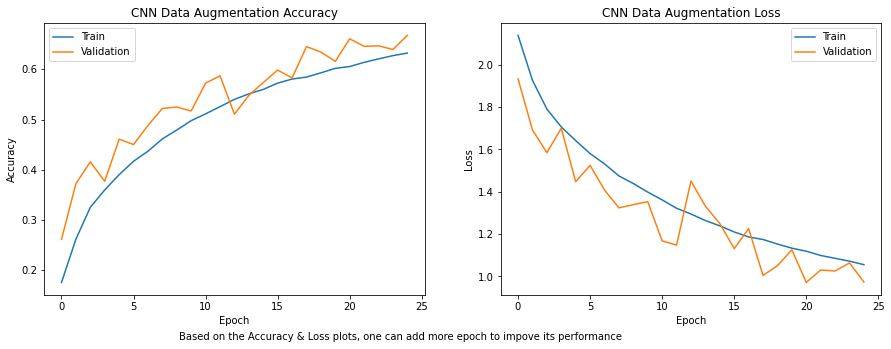

In [18]:
# Plot Model Accuracy and Loss
fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(CNN_Data_Aug_history.history['accuracy'])
axs[0].plot(CNN_Data_Aug_history.history['val_accuracy'])
axs[0].set_title('CNN Data Augmentation Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='best')

axs[1].plot(CNN_Data_Aug_history.history['loss'])
axs[1].plot(CNN_Data_Aug_history.history['val_loss'])
axs[1].set_title('CNN Data Augmentation Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='best')

fig.text(0.25, 0, "Based on the Accuracy & Loss plots, one can add more epoch to impove its performance")
plt.show()

In [19]:
# Evaluate performance
CNN_Data_Aug_scores = CNN_Data_Aug_model.evaluate(x_test, y_test, verbose=1)
print('Test Accuracy:', CNN_Data_Aug_scores[1])
print('Test Loss:', CNN_Data_Aug_scores[0])

10000/10000 [==============================] - 1s 94us/step
Test Accuracy: 0.6675999760627747
Test Loss: 0.9733173428535461


## Step 9: [ Solution 3 ] Pretrained VGG19 Model as Feature Extractor to Train a Conventional Machine Learning Classifier

In [20]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

base_model = VGG19(weights='imagenet')
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [21]:
# Source: https://keras.io/api/applications/
# Use a VGG19 pre-trained on ImageNet and builds a model whose output is the output of the 'fc2' layer of the original model
# Use the pre-trained CNN as a feature extractor by run an image through the network and extract a (4096-D) feature vector 

extractor_model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

img_path = 'elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

fc2_features = extractor_model.predict(x)
fc2_features.shape

(1, 4096)

In [22]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.zoom.html
from scipy import ndimage

# (32, 32, 3) => (224, 224, 3) = zoom factor is 7
def feature_extraction(model, image_set, zoom_factor = 7):
    """" Method use the pretrained model to extract features """ 
    
    # Variable to hold the features
    extracted_list = []

    for image in image_set:
        resized_img = ndimage.zoom(image, (zoom_factor,zoom_factor,1))
        resized_img = np.expand_dims(resized_img, axis=0)
        feature = model.predict(resized_img)
        extracted_list.append(feature.flatten())

    features_array = np.array(extracted_list)
    return features_array

In [23]:
# Extract Features of the Train and Test Set (THIS WILL TAKES AWHILE)

# Train Set
x_train_feature = feature_extraction(extractor_model, x_train)
print("x_train_feature shape: ", x_train_feature.shape) 

# Test Set
x_test_feature = feature_extraction(extractor_model, x_test)
print("x_test_feature shape: ", x_test_feature.shape) 

x_train_feature shape:  (50000, 4096)
x_test_feature shape:  (10000, 4096)


In [24]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.ensemble import RandomForestClassifier

# Train a Conventional ML Classifier using the extracted feature 
forest_clf = RandomForestClassifier(random_state=45, criterion="entropy")
forest_clf.fit(x_train_feature, y_train)

RandomForestClassifier(criterion='entropy', random_state=45)

In [25]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
from sklearn.metrics import accuracy_score

# Evaluate accuracy on test set
y_pred = forest_clf.predict(x_test_feature)
forest_clf_score = accuracy_score(y_test, y_pred)
print("Random Forest Classifer Accuracy Score: ", forest_clf_score)

print("\n Note: The score is very low with default configurations so need to preprocess the input before fit it")
print("'Coming Soon' since this solution takes a lot to time to run")

Random Forest Classifer Accuracy Score:  0.1611

 Note: The score is very low with default configurations so need to preprocess the input before fit it
'Coming Soon' since this solution takes a lot to time to run


## Step 10: [ Solution 4 ] Pretrained VGG19 Model as the Base Model with Additional Layers

In [26]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

# Default input size for VGG19 is 224x224
# It should have exactly 3 inputs channels, and width and height should be no smaller than 32
# => Decided to configure the input_shape equal to the shape of the Cifar-10 which is (32,32,3) so no need to resize them
pretrained_model_VGG = VGG19(weights='imagenet', include_top=False, input_shape = (32,32,3))
pretrained_model_VGG.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [27]:
# Freeze the base model 
pretrained_model_VGG.trainable = False

# Inspecting Trainable and Non-trainable weights
print("Total number of weights: ", len(pretrained_model_VGG.weights))
print("Trainable_weights: ", len(pretrained_model_VGG.trainable_weights))
print("Non_trainable_weights:", len(pretrained_model_VGG.non_trainable_weights))

Total number of weights:  32
Trainable_weights:  0
Non_trainable_weights: 32


In [28]:
# Adding layers 
x = pretrained_model_VGG.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
predictions = Dense(10, activation="softmax")(x)

# Create the final model 
TL_model = Model(inputs = pretrained_model_VGG.input, outputs = predictions)
TL_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [29]:
# Training Configuration
batch_size = 64
epochs = 5

# Compile the model
TL_model.compile(loss=keras.losses.categorical_crossentropy, metrics=['accuracy'], 
                    optimizer =keras.optimizers.rmsprop(lr=0.0001, decay=1e-6))

# Train the model 
TL_model_history = TL_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                                 validation_data=(x_test, y_test), shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 34s 683us/step - loss: 1.3475 - accuracy: 0.5316 - val_loss: 1.0154 - val_accuracy: 0.6650
Epoch 2/5
50000/50000 [==============================] - 35s 692us/step - loss: 0.7622 - accuracy: 0.7562 - val_loss: 0.9355 - val_accuracy: 0.7045
Epoch 3/5
50000/50000 [==============================] - 36s 714us/step - loss: 0.5757 - accuracy: 0.8163 - val_loss: 0.6659 - val_accuracy: 0.7913
Epoch 4/5
50000/50000 [==============================] - 35s 696us/step - loss: 0.4741 - accuracy: 0.8482 - val_loss: 0.7305 - val_accuracy: 0.7834
Epoch 5/5
50000/50000 [==============================] - 35s 709us/step - loss: 0.4079 - accuracy: 0.8724 - val_loss: 0.6812 - val_accuracy: 0.8028


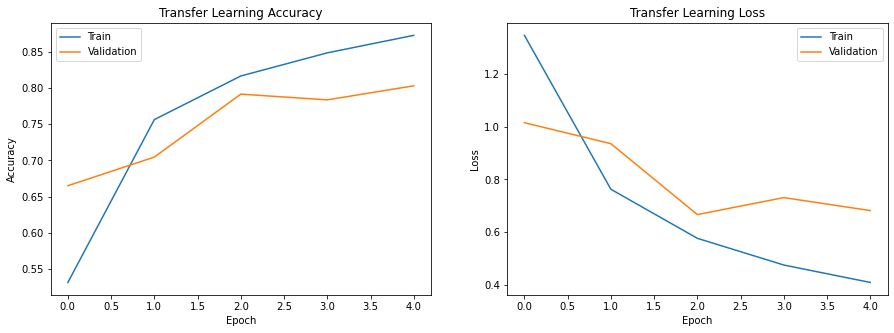

In [30]:
# Plot Model Accuracy and Loss
fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(TL_model_history.history['accuracy'])
axs[0].plot(TL_model_history.history['val_accuracy'])
axs[0].set_title('Transfer Learning Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='best')

axs[1].plot(TL_model_history.history['loss'])
axs[1].plot(TL_model_history.history['val_loss'])
axs[1].set_title('Transfer Learning Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='best')

plt.show()

In [31]:
# Score trained model.
TL_model_scores = TL_model.evaluate(x_test, y_test, verbose=1)
print('Test Accuracy:', TL_model_scores[1])
print('Test Loss:', TL_model_scores[0])

10000/10000 [==============================] - 3s 337us/step
Test Accuracy: 0.8027999997138977
Test Loss: 0.6812350732564926


### Classifiers Result
Note: Solution 1 & Solution 2 trained for 25 epochs while Solution 4 only trained for 5 epochs

In [32]:
print('[Solution 1] CNN Built From Scratch: ')
print('\t Test Accuracy:', CNN_scores[1])
print('\t Test Loss:', CNN_scores[0])

print('\n [Solution 2] CNN Built From Scratch with Data Augmentation: ')
print('\t Test Accuracy:', CNN_Data_Aug_scores[1])
print('\t Test Loss:', CNN_Data_Aug_scores[0])

print('\n [Solution 3] Pretrained VGG19 Model as Feature Extractor to Train Random Forest Classifier: ')
print("\t Test Accuracy: ", forest_clf_score)

print('\n [Solution 4] Pretrained VGG19 Model as the Base Model with Additional Layers: ')
print('\t Test Accuracy:', TL_model_scores[1])
print('\t Test loss:', TL_model_scores[0])

[Solution 1] CNN Built From Scratch: 
	 Test Accuracy: 0.7559999823570251
	 Test Loss: 0.716627716255188

 [Solution 2] CNN Built From Scratch with Data Augmentation: 
	 Test Accuracy: 0.6675999760627747
	 Test Loss: 0.9733173428535461

 [Solution 3] Pretrained VGG19 Model as Feature Extractor to Train Random Forest Classifier: 
	 Test Accuracy:  0.1611

 [Solution 4] Pretrained VGG19 Model as the Base Model with Additional Layers: 
	 Test Accuracy: 0.8027999997138977
	 Test loss: 0.6812350732564926
